# Missing Values Imputation

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


path = kagglehub.dataset_download("mansoordaku/ckdisease", path="kidney_disease.csv")
print("Dataset Path: ", path)

df = pd.read_csv(path)

Dataset Path:  /home/marius/.cache/kagglehub/datasets/mansoordaku/ckdisease/versions/1/kidney_disease.csv


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

In [3]:
# first let's drop the "id" column
df = df.drop("id", axis=1)

# replacing that extra "ckd	" with "ckd"
df = df.replace("ckd\t", "ckd")

# applying label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

list_of_columns = ["classification", "rbc", "pc", "pcc", "ba", "bgr", "htn", "dm", "cad", "appet", "pe", "ane"]
for column_name in list_of_columns:
    df[column_name] = le.fit_transform(df[column_name])

# removing unexpected characters 
df = df.replace('\t?', np.nan)
df = df.replace('	?', np.nan)

# covert to numeric
list_to_convert = ["pcv","wc", "rc"]

for column_name in list_to_convert:
    df[column_name] = pd.to_numeric(df[column_name])


### Missing Values Bar Plot 

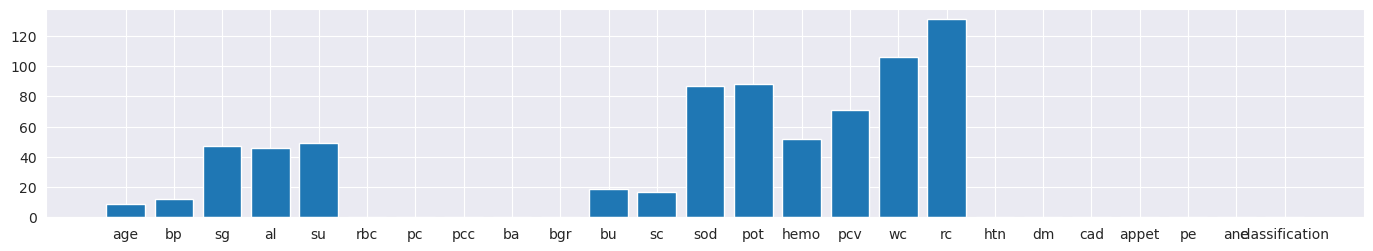

In [4]:
fig, ax = plt.subplots(figsize=(17, 2.7))

ax.bar(df.columns, df.isnull().sum())
plt.show()

### Splitting data into training and testing

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from reparo import CDI, FRNNI, HotDeckImputation, KNNImputer, PMM, SICE, MICE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

imputers = [
    SimpleImputer(strategy="mean"), 
    SimpleImputer(strategy="median"),
    SimpleImputer(strategy="most_frequent"),
    SimpleImputer(strategy="constant", fill_value=0),
    CDI(),
    FRNNI(),
    HotDeckImputation(),
    KNNImputer(),
    PMM(),
    SICE(),
    MICE(),
]

models = [
    LogisticRegression(max_iter=10**10),
    GaussianNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
]

features = df.drop("classification", axis=1).to_numpy()
classification = df["classification"].to_numpy()


columns = ["Imputation algorithm", "Prediction algorithm", "Accuracy"]
results = pd.DataFrame(columns=columns)
for imputer in imputers:
    input_x = features.copy()
    
    imputer.fit(input_x)
    input_x = imputer.transform(input_x)
    
    x_train, x_test, y_train, y_test = train_test_split(input_x, classification, test_size=0.3, random_state=42)
    
    for model in models:
        
        model.fit(x_train, y_train)
        
        predicted = model.predict(x_test)
        
        accuracy = accuracy_score(y_test, predicted)
        results = pd.concat([results, pd.DataFrame([[imputer, model.__class__.__name__, accuracy]], columns=columns)], ignore_index=True)

results

/tmp/ipykernel_31701/1653505299.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([[imputer, model.__class__.__name__, accuracy]], columns=columns)], ignore_index=True)
/home/marius/.loacal/share/anaconda3/lib/python3.12/site-packages/reparo/PMM.py:80: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  beta_zviozdacika = np.random.multivariate_normal(
/home/marius/.loacal/share/anaconda3/lib/python3.12/site-packages/reparo/MICE.py:56: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3

,Imputation algorithm,Prediction algorithm,Accuracy
0,SimpleImputer(),LogisticRegression,0.983333
1,SimpleImputer(),GaussianNB,0.933333
2,SimpleImputer(),DecisionTreeClassifier,0.966667
3,SimpleImputer(),RandomForestClassifier,1.000000
4,SimpleImputer(strategy='median'),LogisticRegression,0.991667
5,SimpleImputer(strategy='median'),GaussianNB,0.941667
6,SimpleImputer(strategy='median'),DecisionTreeClassifier,0.975000
7,SimpleImputer(strategy='median'),RandomForestClassifier,1.000000
8,SimpleImputer(strategy='most_frequent'),LogisticRegression,0.991667
9,SimpleImputer(strategy='most_frequent'),GaussianNB,0.941667


In [17]:
results.sort_values(by=[ "Prediction algorithm", "Accuracy"], ascending=False)

,Imputation algorithm,Prediction algorithm,Accuracy
3,SimpleImputer(),RandomForestClassifier,1.000000
7,SimpleImputer(strategy='median'),RandomForestClassifier,1.000000
11,SimpleImputer(strategy='most_frequent'),RandomForestClassifier,1.000000
15,"SimpleImputer(fill_value=0, strategy='constant')",RandomForestClassifier,1.000000
19,CDI(),RandomForestClassifier,1.000000
23,FRNNI(),RandomForestClassifier,1.000000
35,PMM(),RandomForestClassifier,1.000000
39,SICE(),RandomForestClassifier,1.000000
43,MICE(),RandomForestClassifier,1.000000
27,HotDeckImputation(),RandomForestClassifier,0.991667


### Conclusion
As we could see from the results RandomForest is again a great model for predicting, not influenced by the missing data or the disturbance of new added values showing great results for almost any imputer. There also could be observed that HotDeckImputation adds a disturbance in almost all models which results in a lower accuracy but this is not totally true. Although there are some differences in accuracy across Imputation algorithm they are generally pretty small so that in scope of one prediction model accuracies results didn't change much. This could mean that we could sort them by accuracy but as we could observe different imputation algorithms gives different results for different models. So we can't sort them by performance as that there is not a universal truth. And also there is not a single good fit for one model there are multiple so that I will refer to this table for future needs in deciding the best suited imputation algorithm.